### System of advection-diffusion-reaction equations

In [1]:
from GDM_PCE import *

In [2]:
np.random.seed(1)

In [3]:
n_grass_ = [16, 28, 40]

In [4]:
Error = []
N_clusters = []
Y_real, Y_recon, Diff, L2, R2, g_all, l_all, coord_all = [], [], [], [], [], [], [], []

for i in range(len(n_grass_)):
    
    print('----Iteration: {} ----'.format(i))
    
    # read x data
    file = np.load('data/stochastic_parameters_example-3.npz')
    x = file['X']
    n_samples = x.shape[0]

    # For the PCE model
    # Distributions
    pdf1 = Uniform(loc=0.005, scale=0.01)  # diffusion coefficient
    pdf2 = Uniform(loc=7, scale=13)  # reaction rate

    margs = [pdf1, pdf2]
    joint = JointInd(marginals=margs)
    
    file2 = np.load('data/fenics_output.npz')
    data = file2['Y']
    u = file2['u']
    points = file2['p']
    tri = file2['tri']
    
    n = data.shape[1]
    
    # Train data
    cc = 600
    x_train = x[:cc,:]
    x_test = x

    y_train = data[:cc,:,:]
    y_test = data
    
    x = x_train
    data = y_train
    
    start_time = time.time()

    g, coord, Grass,  residuals, index, evals = GDMaps(data=data, n_evecs=10, n_parsim=3, p=n_grass_[i]).get()  # Perform GDMAps
    pce, error = PceModel(x=x, g=g, dist_obj=joint, max_degree=3, verbose=False).get()  # Perform PCE on the manifold
    # print('Error of PCE:', error)

    print("--- Surrogate - %s seconds ---" % (time.time() - start_time))
    
    # Adaptive clustering
    start_time = time.time()
    mat, indices, kmeans, L, n_clust, error_cl, clusters = AdaptClust(n_clust_max=60, Gr_object=Grass, data=g)
    print("--- Adaptive clustering - %s seconds ---" % (time.time() - start_time))
    
    Error.append(error_cl)
    N_clusters.append(clusters)
    g_all.append(g)
    l_all.append(L)
    coord_all.append(coord)
    
    # Interpolators
    models_all, pce_sigmas, dims = Interpolators(x=x, data=g, mat=mat, indices=indices, n_clust=n_clust, Gr=Grass, joint=joint)
    
    # Predictions
    start_time = time.time()   

    # n_pred = n_samples - x_train.shape[0]
    # x_pred = x_test[:n_pred,:]  # new samples
    x_pred = x_test
    
    start_time = time.time()   

    y_real = []
    for k in range(x_pred.shape[0]):
        y_real.append(y_test[k,:,:])
    
    Y_real.append(y_real)
    
    start_time = time.time()   
    
    y_recon, l2, r2, diff = Prediction(x_pred=x_pred, y_real=y_real, models_all=models_all, kmeans=kmeans, mat=mat,
                                               pce=pce, pce_sigmas=pce_sigmas, Gr=Grass, dims=dims)

    Y_recon.append(y_recon)
    Diff.append(diff)
    L2.append(l2)
    R2.append(r2)
    
    print("--- Out-of-sample predictions with GDMaps PCE - %s seconds ---" % (time.time() - start_time))
    print('-------------------------------------------------------------------------------')
    print('')

----Iteration: 0 ----
Grassmann projection rank is:  16
--- Surrogate - 6.603823184967041 seconds ---
A cluster of less than 5 points was detected. The algorithm stopped.
--- Adaptive clustering - 474.6630358695984 seconds ---
Validation error of PCE of sigmas:  [0.1191814 0.1297957 0.814448  0.7411877 0.325748  0.264787  0.2810005
 0.59708   0.3418147 0.6208323 0.476944  0.7505509 0.7380088 0.6615911
 0.7474656 0.5128608]
--- Out-of-sample predictions with GDMaps PCE - 136.56077003479004 seconds ---
-------------------------------------------------------------------------------

----Iteration: 1 ----
Grassmann projection rank is:  28
--- Surrogate - 8.188676118850708 seconds ---
A cluster of less than 5 points was detected. The algorithm stopped.
--- Adaptive clustering - 642.1775870323181 seconds ---
Validation error of PCE of sigmas:  [0.1191814 0.1297957 0.814448  0.7411877 0.325748  0.264787  0.2810005
 0.59708   0.3418147 0.6208323 0.476944  0.7505509 0.7380088 0.6615911
 0.74746

In [5]:
# Save results
np.savez('data/Results-Example-3.npz', x1=Error, x2=N_clusters, x3=g_all, x4=l_all, x5=coord_all, x6=Y_real, x7=Y_recon, x8=Diff, x9=L2, x10=R2)

# Load file
file_res = np.load('data/Results-Example-3.npz', allow_pickle=True)
Error = file_res['x1']
N_clusters = file_res['x2']
g_all = file_res['x3']
l_all = file_res['x4']
coord_all = file_res['x5']
Y_real = file_res['x6']
Y_recon = file_res['x7']
Diff = file_res['x8']
L2 = file_res['x9']
R2 = file_res['x10']

### Plot error vs number of clusters

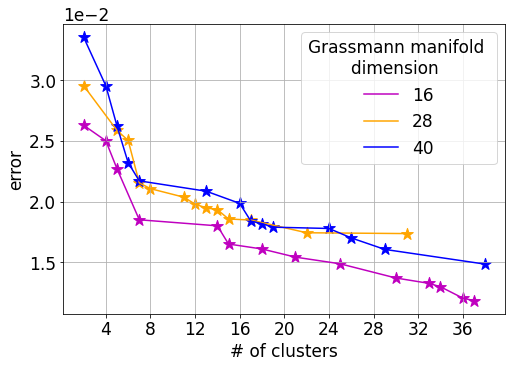

In [6]:
command = ['mkdir', 'figures']
subprocess.run(command)
command = ['mkdir', 'figures/Example3']
subprocess.run(command)

plt.rcParams.update({'font.size': 17})
fig, ax = plt.subplots(figsize=(7, 5), constrained_layout=True)
col = ['m', 'orange', 'b']

for i in range(len(n_grass_)):
    plt.plot(N_clusters[i], Error[i], c=col[i], label='{}'.format(n_grass_[i]))
    plt.scatter(N_clusters[i], Error[i], c=col[i], marker='*', s=150)

plt.ylabel('error')
plt.xlabel('# of clusters')
plt.legend(title='Grassmann manifold \n        dimension')
ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.grid()
plt.savefig('figures/Example3/Error-vs-number-of-clusters.png', bbox_inches='tight', dpi=300)

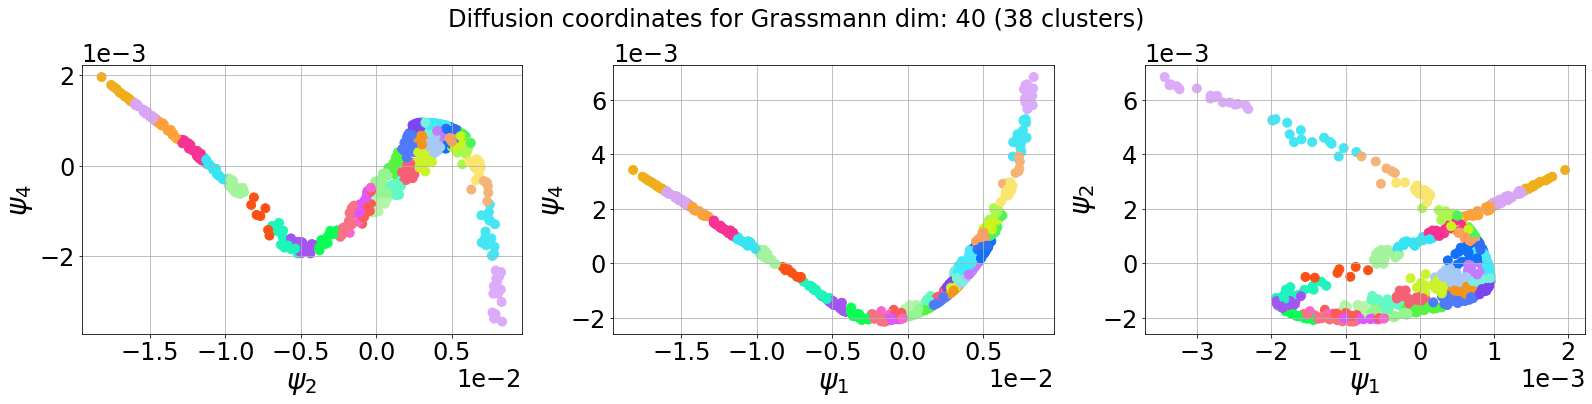

In [7]:
# Plot diffusion coordinates of the last n_samples_
plt.rcParams.update({'font.size': 24})

# Choose the last n_samples_
g = g_all[-1]
L = l_all[-1]
coord = coord_all[-1]

nlabels = np.unique(L).shape[0]
cmap = rand_cmap(nlabels=nlabels, type='bright', first_color_black=False, verbose=False)

comb1 = list(it.combinations(list(coord), 2))
comb2 = list(it.combinations([i for i in range(coord.shape[0])], 2))

# Plot first three plots
if coord.shape[0] > 1:
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(22,5.5), constrained_layout=True)
    fig.suptitle('Diffusion coordinates for Grassmann dim: {} ({} clusters)'.format(n_grass_[-1], N_clusters[-1][-1]), fontsize=24)
    j = 2
    for i in range(3):
        ax[i].scatter(g_all[0][:, comb2[i][0]], g_all[0][:, comb2[i][1]], s=80, c=L, cmap=cmap)
        ax[i].set_xlabel(r'$\psi_{}$'.format(comb1[j][0]), fontsize=28)
        ax[i].set_ylabel(r'$\psi_{}$'.format(comb1[j][1]), fontsize=28)
        ax[i].grid('True')
        ax[i].ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
        # plt.legend()
        # ax[i].set_title('Training realizations: {}'.format(trunc[i]))
        j -= 1
    plt.savefig('figures/Example3/Diffusion-coord.png', bbox_inches='tight', dpi=500)

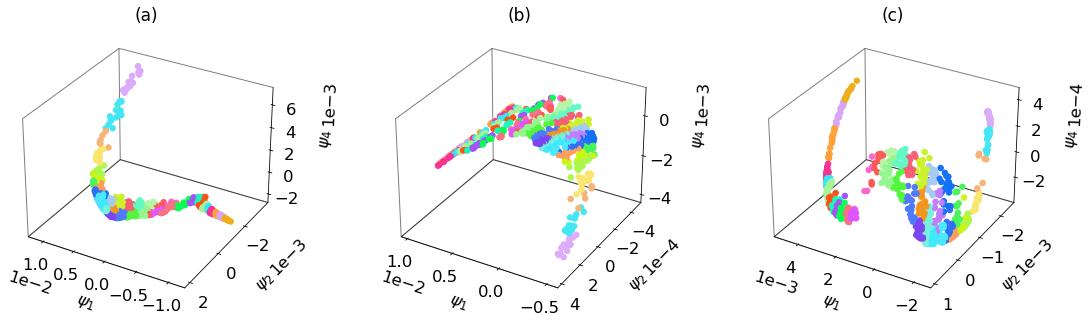

In [8]:
# 3D plot
# 3D scatter plot of diffusion coordinates
import matplotlib.ticker as ticker
import string
plt.rcParams.update({'font.size': 16.5})
fig = plt.figure(figsize = (16,5), constrained_layout=True)
w = 2
#===============
#  First subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 3, 1, projection='3d')

ax.scatter3D(g_all[0][:,0], g_all[0][:,1], g_all[0][:,2], c=L, s=30, alpha=1, cmap=cmap)
ax.view_init(30, 120)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.set_xlabel(r'$\psi_1$', labelpad=8)
ax.set_ylabel(r'$\psi_2$', labelpad=14)
ax.set_zlabel(r'$\psi_4$', labelpad=14)
ax.set_xlim(-0.012,0.012)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('(a)', fontsize=17)
#===============
#  Second subplot
#===============
# set up the axes for the first plot
ax = fig.add_subplot(1, 3, 2, projection='3d')

ax.scatter3D(g_all[1][:,0], g_all[1][:,1], g_all[1][:,2], c=L, s=30, alpha=1, cmap=cmap)
ax.view_init(30, 120)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.set_xlabel(r'$\psi_1$', labelpad=8)
ax.set_ylabel(r'$\psi_2$', labelpad=14)
ax.set_zlabel(r'$\psi_4$', labelpad=14)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('(b)', fontsize=17)
#===============
# Thrid subplot
#===============
# set up the axes for the second plot
ax = fig.add_subplot(1, 3, 3, projection='3d')

ax.scatter3D(g_all[2][:,0], g_all[2][:,1], g_all[2][:,2], c=L, s=30, alpha=1, cmap=cmap)
ax.view_init(30, 120)
#ax.tick_params(axis='both', which='major', labelsize=10)

ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0), useOffset=False, useLocale=False)
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.set_xlabel(r'$\psi_1$', labelpad=8)
ax.set_ylabel(r'$\psi_2$', labelpad=14)
ax.set_zlabel(r'$\psi_4$', labelpad=14)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
ax.set_title('(c)', fontsize=17)
fig.tight_layout(pad=2.0)
plt.savefig('figures/Example3/Diffusion-coord-chem-3d.png', bbox_inches='tight', dpi=500)

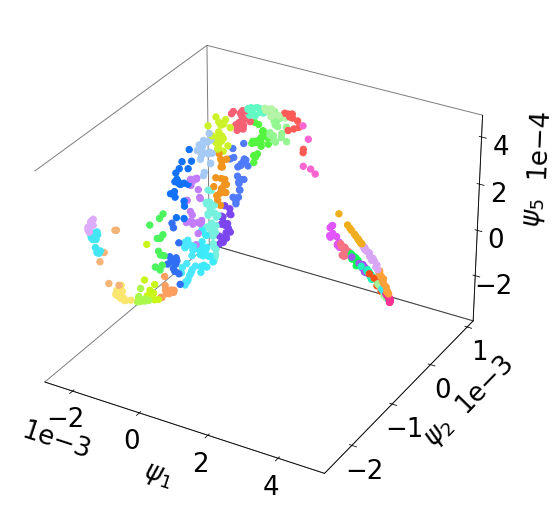

In [9]:
# 3D scatter plot of diffusion coordinates
import matplotlib.ticker as ticker
plt.rcParams.update({'font.size': 26})
fig = plt.figure(figsize = (10, 7), constrained_layout=True)
ax = plt.axes(projection ="3d") 
ax.scatter3D(g[:,0], g[:,1], g[:,2], c=L, s=40, alpha=1, cmap=cmap)
#ax.view_init(30, 70)
ax.ticklabel_format(style='sci', axis='both', scilimits=(0, 0))
ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.zaxis.pane.set_edgecolor('black')
ax.set_xlabel(r'$\psi_1$', labelpad=14)
ax.set_ylabel(r'$\psi_2$', labelpad=14)
ax.set_zlabel(r'$\psi_5$', labelpad=14)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
#plt.title("simple 3D scatter plot")
plt.savefig('figures/Example3/Diffusion-coord-3d.png', bbox_inches='tight', dpi=500)

### Reference vs prediction plot

samples: [1.27188820e-02 1.61384186e+01]


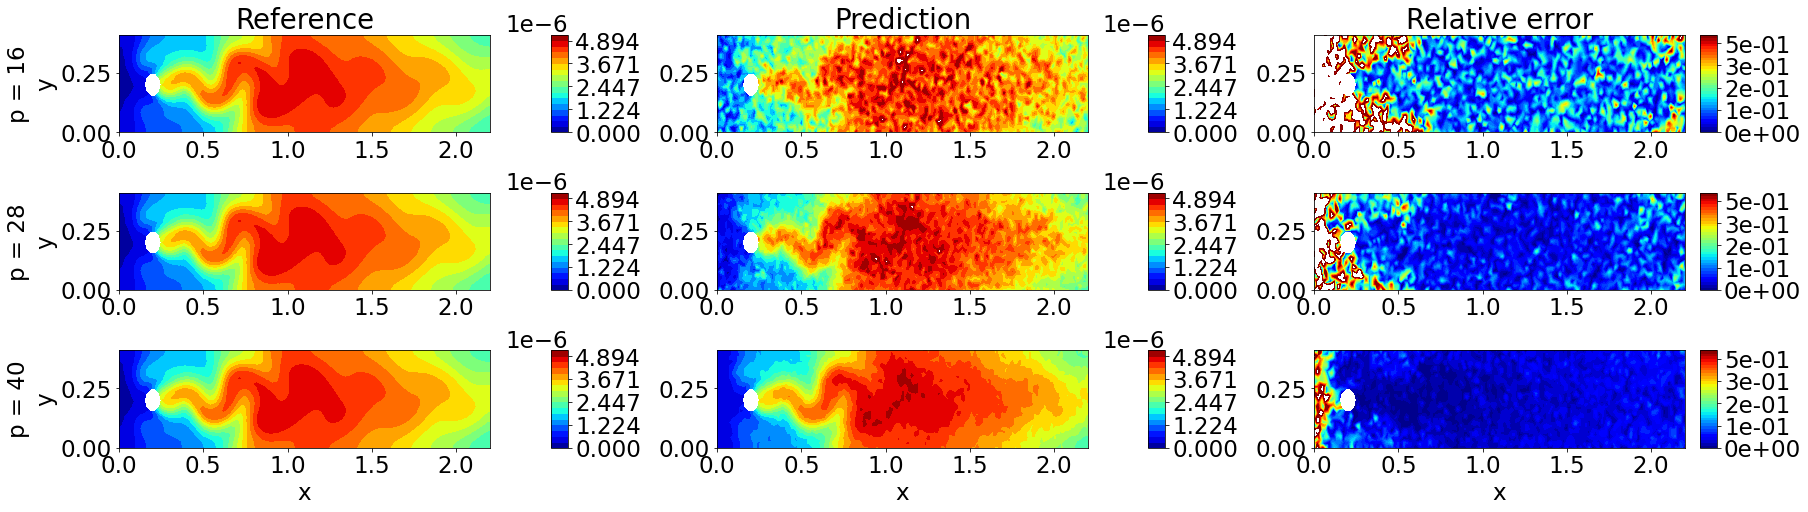

In [10]:
# Plot 3 random test realizations with predictions and error
# Prediction vs Reference
plt.rcParams.update({'font.size': 23})
fig, axs = plt.subplots(3, 3, figsize=(25, 7), constrained_layout=True)

# Plot here one random sample for the multiple Grassmann manifold dimensions
# -------
i = 0
j = 90 # Choose sample
for row in range(3):
    for col in range(3):
        ax = axs[row, col]
        if col == 0:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, Y_real[i][j].reshape(n*n), levels=np.linspace(0, 5.2e-6, 18), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.ax.locator_params(nbins=6)
            ax.set_ylabel('p = {}\ny'.format(n_grass_[i]))
        if col == 1:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, Y_recon[i][j].reshape(n*n), levels=np.linspace(0, 5.2e-6, 18), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.ax.locator_params(nbins=6)
        if col == 2:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, Diff[i][j].reshape(n*n), levels=np.linspace(0, 0.5, 36), cmap='jet');
            # levels=np.linspace(0, 2e-2, 28)
            cbar = plt.colorbar(pcm, ax=ax, format='%.0e')
            cbar.ax.locator_params(nbins=6)
        if col==0 and row==0:
            ax.set_title('Reference')
        if col==1 and row==0:
            ax.set_title('Prediction')
        if col==2 and row==0:
            ax.set_title('Relative error')
        if row==2:
            ax.set_xlabel('x')
    i += 1
            
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.4)
plt.savefig('figures/Example3/Reference-vs-prediction.png', bbox_inches='tight', transparent=True, dpi=500)

print('samples: {}'.format(x[j,:]))

In [11]:
# In addition to the above we'll show a Table with the mean and std of the l2 and r2 values for the 10,000 samples
# Compute the values next

# Compute mean and variance of errors
l2_mean = [np.round(np.mean(L2[i]), 6) for i in range(len(L2))]
l2_std = [np.round(np.std(L2[i]), 6) for i in range(len(L2))]

R2_mean = [np.round(np.mean(R2[i]), 6) for i in range(len(R2))]
R2_std = [np.round(np.std(R2[i]), 6) for i in range(len(R2))]

for i in range(3):
    print('Dim: {}'.format(n_grass_[i]))
    print('L2 mean {:e} '.format(l2_mean[i]))
    print('L2 std: {:e} '. format(l2_std[i]))
    print('R2 mean: {:e} '.format(R2_mean[i]))
    print('R2 std: {:e} '.format(R2_std[i]))
    print('')

Dim: 16
L2 mean 2.108000e-01 
L2 std: 3.940900e-02 
R2 mean: 7.271550e-01 
R2 std: 3.400800e-02 

Dim: 28
L2 mean 1.096980e-01 
L2 std: 3.496300e-02 
R2 mean: 9.252730e-01 
R2 std: 3.471000e-02 

Dim: 40
L2 mean 6.148200e-02 
L2 std: 4.258500e-02 
R2 mean: 9.718460e-01 
R2 std: 3.783100e-02 



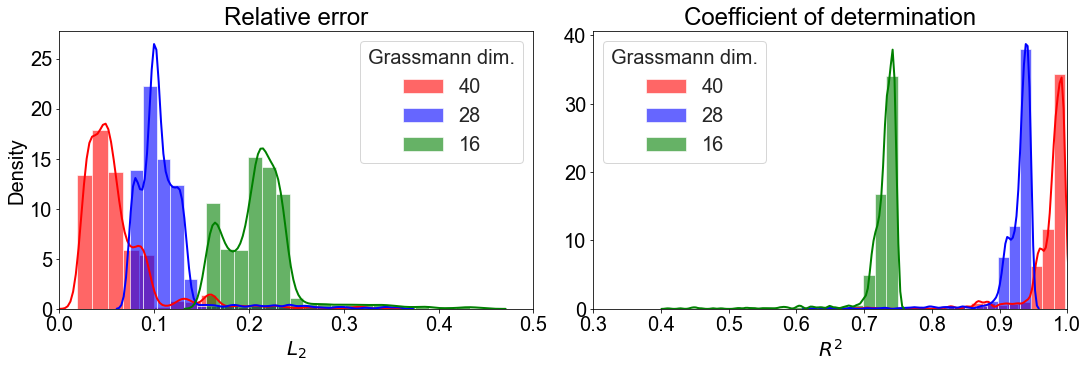

In [12]:
import seaborn as sns
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(1, 2, figsize=(15, 5), constrained_layout=True)
#fig.suptitle('Histogram of errors')

sns.set_style("white")
kwargs = dict(hist_kws={'alpha': .6}, kde_kws={'linewidth': 2})
colors = ['green', 'b', 'red', 'k', 'y', 'g', 'm']
# colors = ['purple', 'blue', 'orange']

for i in range(len(Y_real) - 1, -1, -1):
    sns.distplot(L2[i], ax=ax[0], label='{}'.format(n_grass_[i], l2_mean[i], l2_std[i]),
                 color=colors[i], bins=20, kde='True', **kwargs)
    sns.distplot(R2[i], ax=ax[1], label='{}'.format(n_grass_[i], R2_mean[i], R2_std[i]),
                 color=colors[i], bins=20, kde='True', **kwargs)
    sns.set_style({'axes.grid' : False})

    #ax[0].hist(L2[i], alpha=0.5, density='True', color=colors[i], bins=12,
    #label='Clusters:{}, (μ,σ)=({},{})'.format(n_clusters_[i], l2_mean[i], l2_std[i]))
    #ax[1].hist(R2[i], alpha=0.5, density='True', color=colors[i], bins=14,
    #label='Clusters:{}, (μ,σ)=({},{})'.format(n_clusters_[i], R2_mean[i], R2_std[i]))

ax[0].set_xlim(0, 0.5)
ax[0].set_title('Relative error')
ax[0].legend(fontsize=18)
ax[0].set_ylabel('Density')
ax[0].set_xlabel(r'$L_2$')
#ax[0].grid(True)
ax[1].set_xlim(0.3, 1)
ax[1].set_title('Coefficient of determination')
ax[1].legend(fontsize=18)
ax[1].set_xlabel(r'$R^2$')
#ax[1].grid('True')
ax[0].legend(title='Grassmann dim.')
ax[1].legend(title='Grassmann dim.')

plt.savefig('figures/Example3/Histograms-L2-error-R2-score-adv.png', bbox_inches='tight', dpi=500)

### Moment estimation (UQ)
Comparison with MCS

Compute mean field with MCS and GDMaps PCE

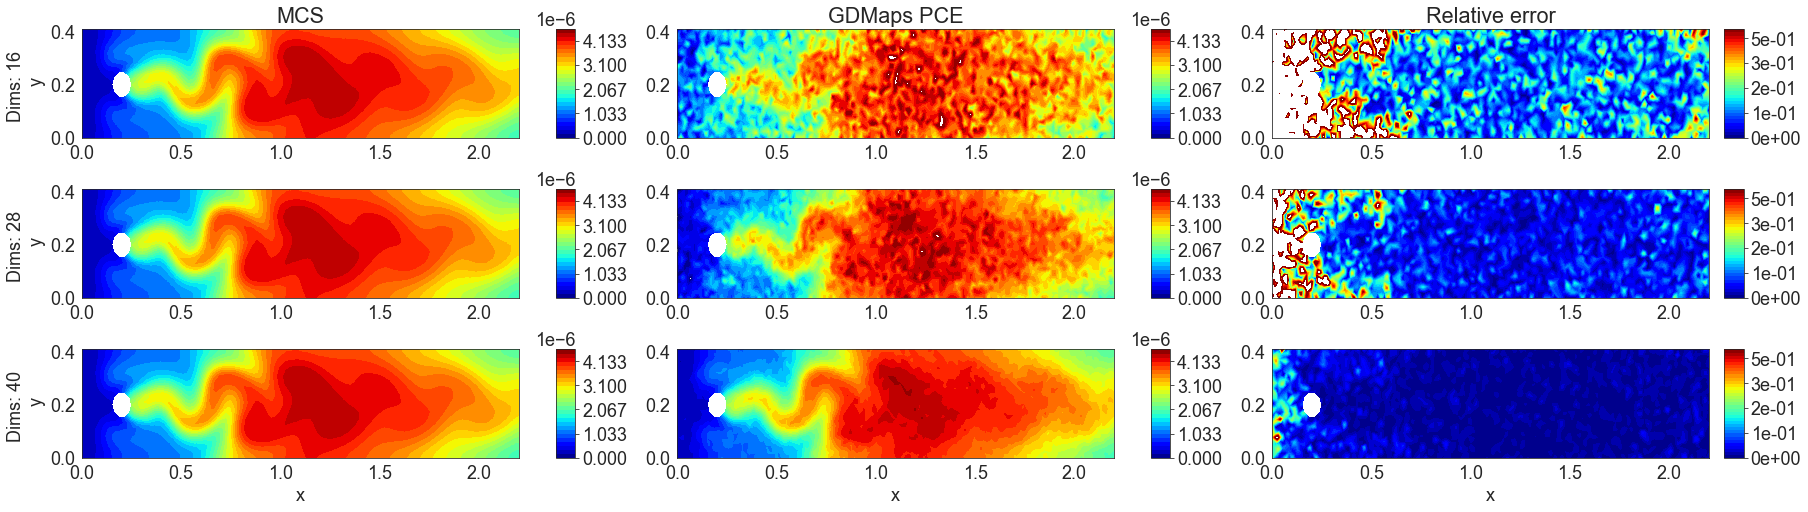

In [13]:
### Make one figure to compare the three different training data

mean_recon, mean_mcs, mean_diff = [], [], []

for i in range(len(n_grass_)):
    mean_recon.append(np.mean(np.array(Y_recon[i]), axis=0).flatten())
    mean_mcs.append(np.mean(np.array(Y_real[i]), axis=0).flatten())
    mean_diff.append(np.abs((mean_mcs[i] - mean_recon[i]) / mean_mcs[i]))

plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(len(n_grass_), 3, figsize=(25, 7), constrained_layout=True)
cm = ['gnuplot2'] * len(n_grass_)
i = 0
for col in range(3):
    for row in range(len(n_grass_)):
        ax = axs[row, col]
        if col == 0:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, mean_mcs[row], levels=np.linspace(0, 4.65e-6, 28), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.ax.locator_params(nbins=6)
            ax.set_ylabel('Dims: {} \n y'.format(n_grass_[i]))
        if col == 1:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, mean_recon[row], levels=np.linspace(0, 4.65e-6, 28), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.ax.locator_params(nbins=6)
        if col == 2:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, mean_diff[row], levels=np.linspace(0, 0.5, 36), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax, format='%.0e')
            cbar.ax.locator_params(nbins=6)
        if col == 0:
            ax.set_ylabel('Dims: {} \n y'.format(n_grass_[row]))
        if col == 1 and row == 0:
            ax.set_title('GDMaps PCE')
        if col == 0 and row == 0:
            ax.set_title('MCS')
        if col == 2 and row == 0:
            ax.set_title('Relative error')
        if row == 2:
            ax.set_xlabel('x')
    i += 1

Compute variance field with MCS and GDMaps PCE

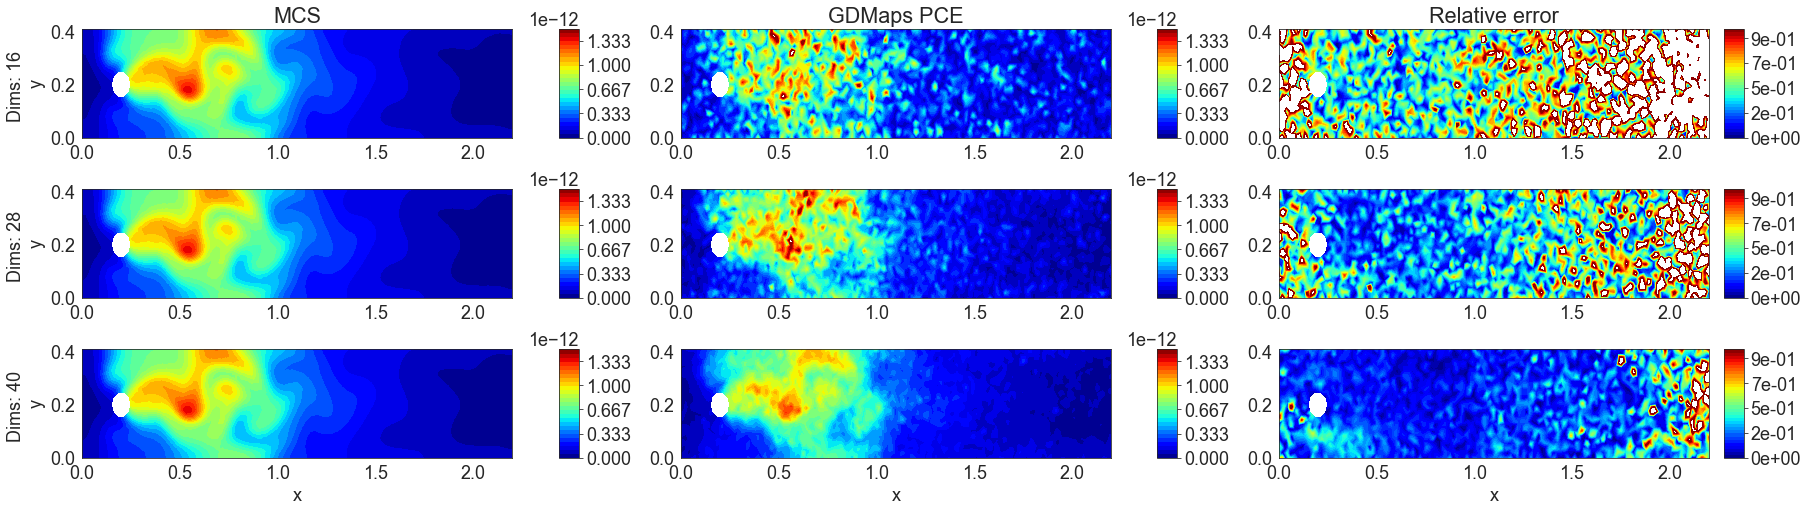

In [14]:
### Make one figure to compare the three different training data

var_recon, var_mcs, var_diff = [], [], []

for i in range(len(n_grass_)):

    var_recon.append(np.var(np.array(Y_recon[i]), axis=0).flatten())
    var_mcs.append(np.var(np.array(Y_real[i]), axis=0).flatten())
    var_diff.append(np.abs((var_mcs[i] - var_recon[i]) / var_mcs[i]).flatten())

plt.rcParams.update({'font.size': 18})
fig, axs = plt.subplots(len(n_grass_), 3, figsize=(25, 7), constrained_layout=True)
i = 0
for col in range(3):
    for row in range(len(n_grass_)):
        ax = axs[row, col]
        if col == 0:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, var_mcs[row], levels=np.linspace(0, 1.5e-12, 28), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.ax.locator_params(nbins=6)
            ax.set_ylabel('Dims: {} \n y'.format(n_grass_[i]))
        if col == 1:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, var_recon[row], levels=np.linspace(0, 1.5e-12, 28), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.ax.locator_params(nbins=6)
        if col == 2:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, var_diff[row], levels=np.linspace(0, 1, 36), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax, format='%.0e')
            cbar.ax.locator_params(nbins=6)
        if col == 0:
            ax.set_ylabel('Dims: {} \ny'.format(n_grass_[row]))
        if col == 0 and row == 0:
            ax.set_title('MCS')
        if col == 1 and row == 0:
            ax.set_title('GDMaps PCE')
        if col == 0 and row == 0:
            ax.set_title('MCS')
        if col == 2 and row == 0:
            ax.set_title('Relative error')
        if row == 2:
            ax.set_xlabel('x')

    i += 1

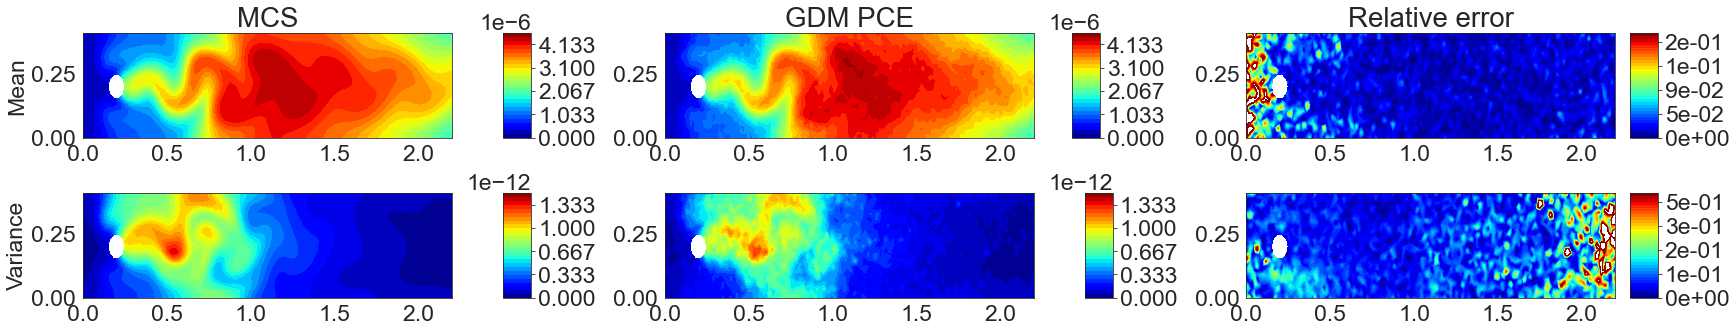

In [15]:
### Moment estimation for n_samples_[0] training data
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size': 23})

fig, axs = plt.subplots(2, 3, figsize=(24, 4.5), constrained_layout=True)
cm = ['gnuplot2'] * len(n_grass_)
i = 0
j = 2
for col in range(3):
    for row in range(2):
        ax = axs[row, col]
        if col == 0 and row == 0:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, mean_mcs[j], levels=np.linspace(0, 4.65e-6, 28), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.ax.locator_params(nbins=6)
            ax.set_ylabel('Dims: {} \n y'.format(n_grass_[i]))
        if col == 1 and row == 0:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, mean_recon[j], levels=np.linspace(0, 4.65e-6, 28), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.ax.locator_params(nbins=6)
        if col == 2 and row == 0:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, mean_diff[j], levels=np.linspace(0, 0.2, 36), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax, format='%.0e')
            cbar.ax.locator_params(nbins=6)
            
        if col == 0 and row == 1:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, var_mcs[j], levels=np.linspace(0, 1.5e-12, 28), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.ax.locator_params(nbins=6)
        if col == 1 and row == 1:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, var_recon[j], levels=np.linspace(0, 1.5e-12, 28), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax)
            cbar.ax.locator_params(nbins=6)
        if col == 2 and row == 1:
            pcm = ax.tricontourf(points[:,0], points[:,1], tri, var_diff[j], levels=np.linspace(0, 0.5, 36), cmap='jet');
            cbar = plt.colorbar(pcm, ax=ax, format='%.0e')
            cbar.ax.locator_params(nbins=6)
        if col == 0 and row==0:
            ax.set_ylabel('Mean')
            ax.set_title('MCS')
        if col == 0 and row==1:
            ax.set_ylabel('Variance')
        if col == 1 and row == 0:
            ax.set_title('GDM PCE')
        if col == 0 and row == 0:
            ax.set_title('MCS')
        if col == 2 and row == 0:
            ax.set_title('Relative error')
        if row == 2:
            ax.set_xlabel('x')
    i += 1
    
#cbar1 = fig.colorbar(pcm1, ax=axs[0:1, :2], location='right', shrink=1, aspect=40)
#cbar1.ax.locator_params(nbins=5)
#cbar2 = fig.colorbar(pcm3, ax=axs[1:2, :2], location='right', shrink=1, aspect=40)
#cbar2.ax.locator_params(nbins=5)
#cbar3 = fig.colorbar(pcm2, ax=axs[:, 2:3], location='right', shrink=1, format='%.0e', aspect=70)
#cbar3.ax.locator_params(nbins=6)
plt.savefig('figures/Example3/Moment-estimation-adv.png', bbox_inches='tight', dpi=500)